# Croston's Method for Intermittent Time Series Forecasting in NumPyro

In this notebook, we will implement Croston's method for intermittent demand forecasting using [`NumPyro`](https://github.com/pyro-ppl/numpyro). Croston's method is a popular forecasting method for intermittent demand data, which is characterized by a large number of zero values. The method is based on the idea of separating the demand size and the demand interval, and then forecasting them separately using simple exponential smoothing. We therefore can leverage on top of the previous post [Notes on Exponential Smoothing with NumPyro](https://juanitorduz.github.io/exponential_smoothing_numpyro/). Once we have the forecasts for the demand size and the demand interval, we can combine them to get the final forecast. For a succinct explanation of Croston's method, I recommend the following blog post: https://www.pmorgan.com.au/tutorials/crostons-method/.

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
import preliz as pz
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.handlers import scope
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsforecast import StatsForecast
from statsforecast.models import CrostonOptimized
from statsforecast.utils import ConformalIntervals

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

We start by generating synthetic time series with many zeros. We use a Poisson distribution to generate the samples:

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

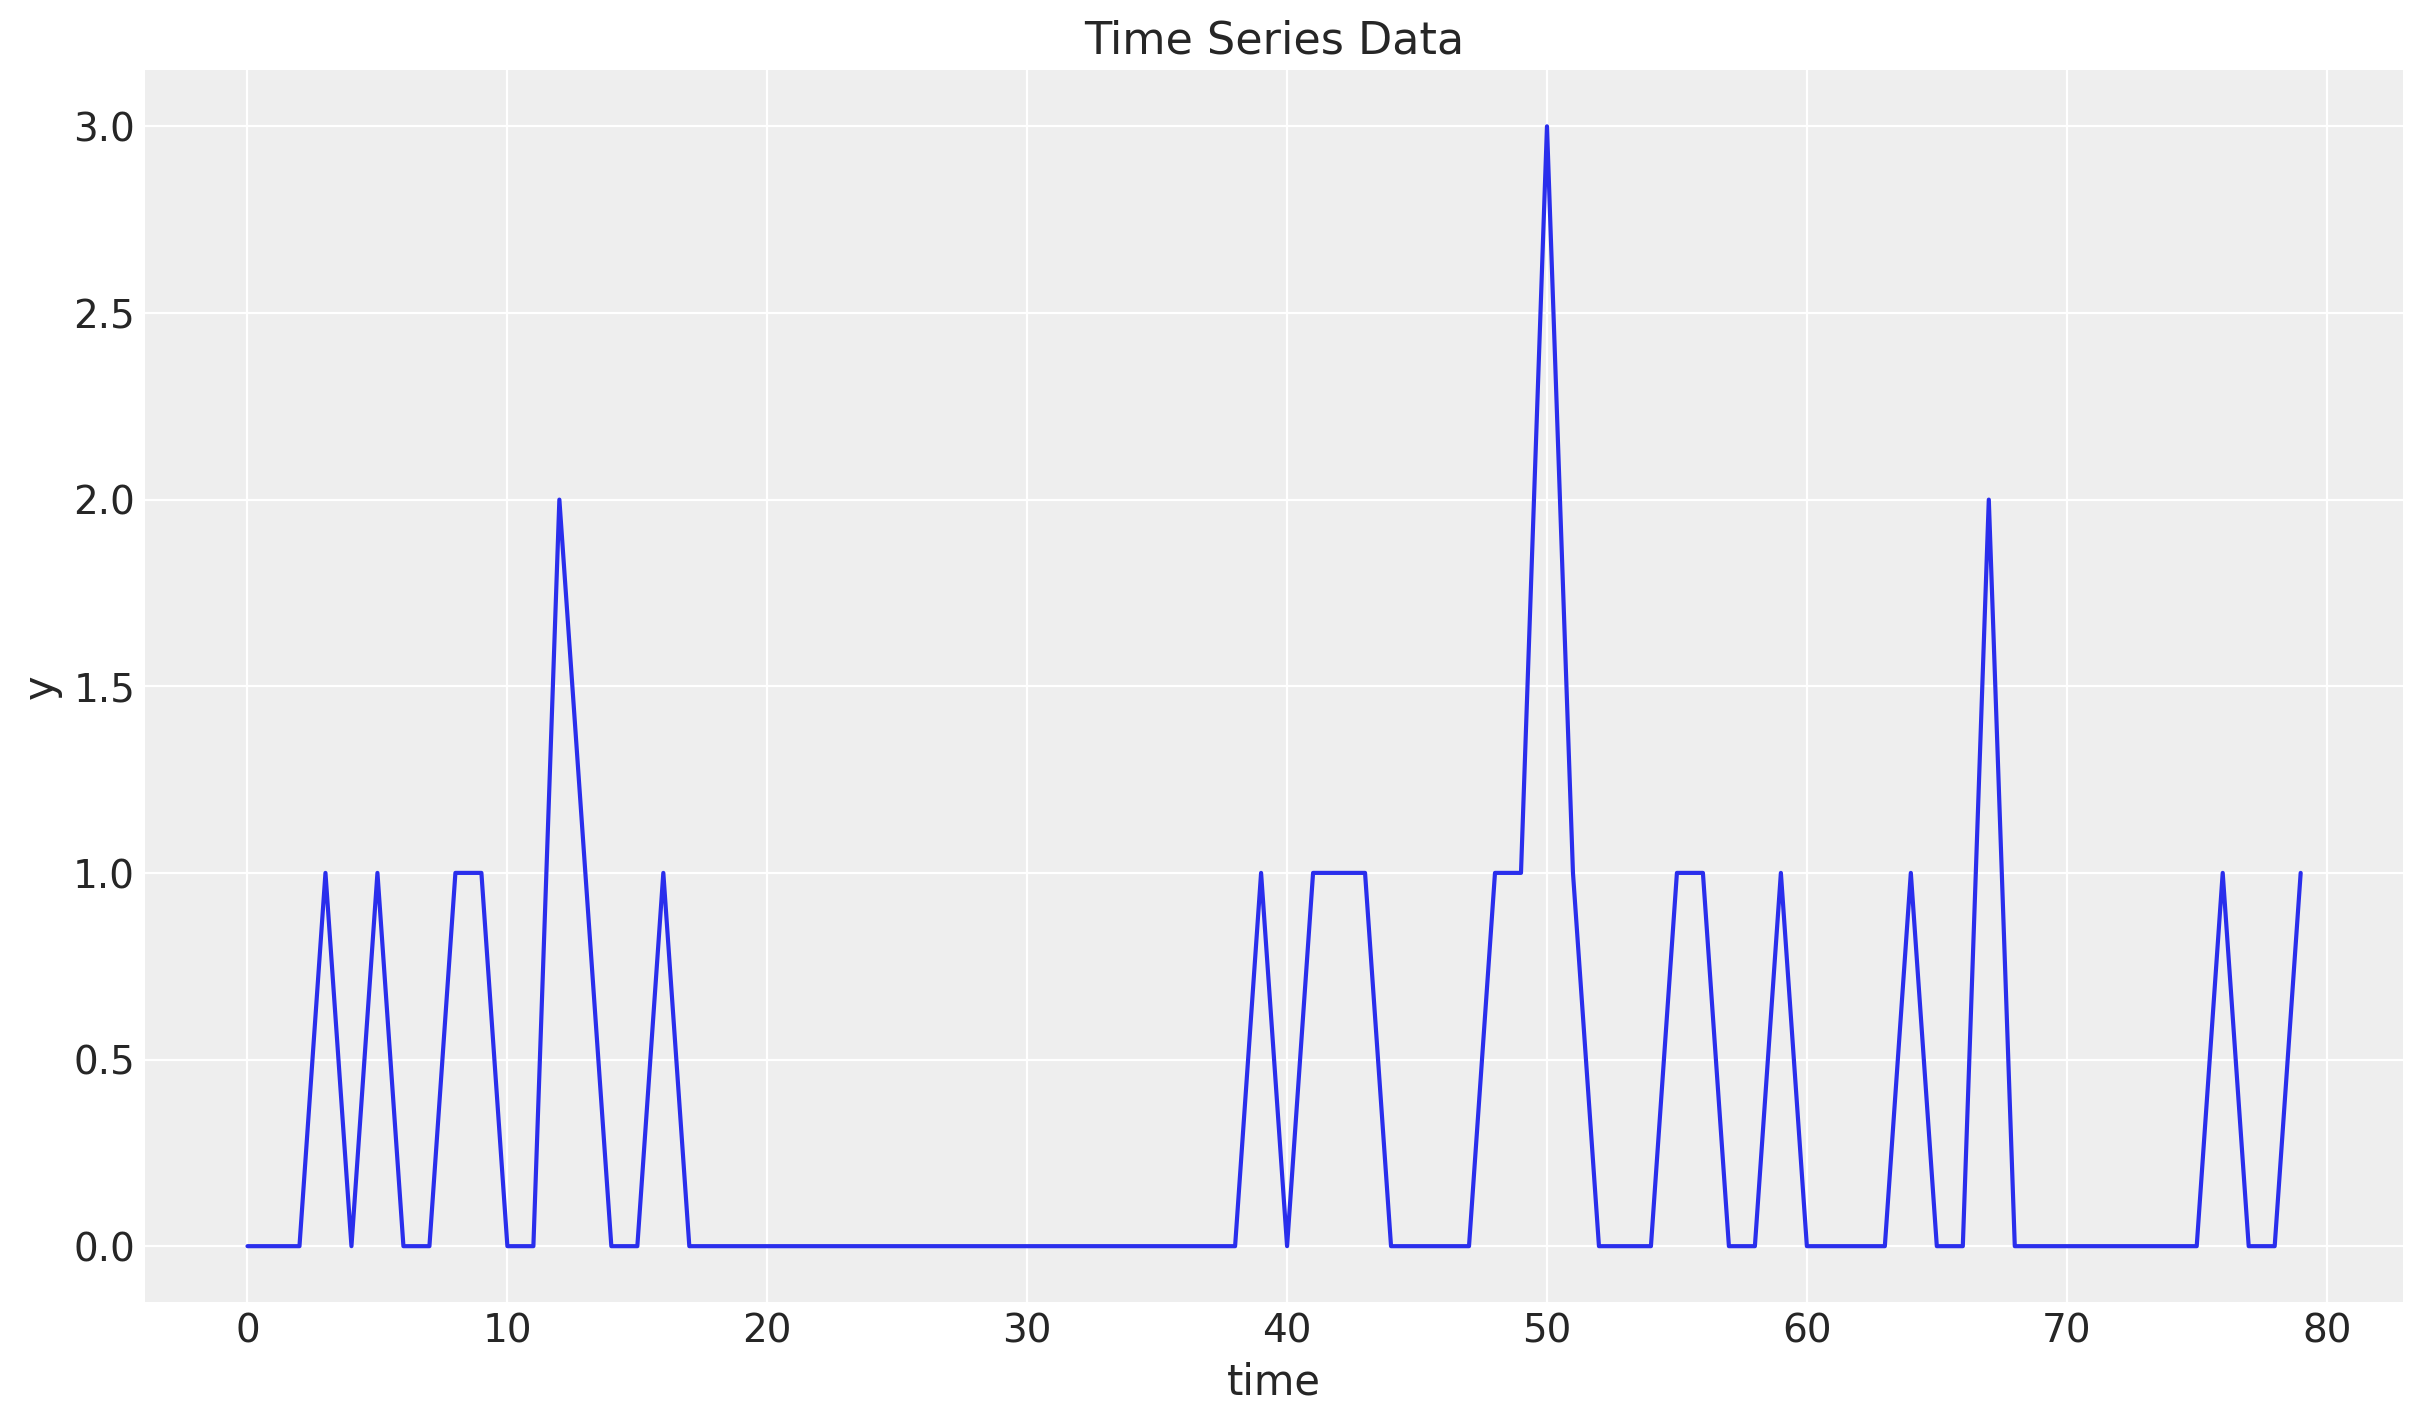

In [2]:
n = 80
lam = 0.3

y = random.poisson(key=rng_key, lam=lam, shape=(n,)).astype(jnp.float32)
t = jnp.arange(y.size)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

## Train-Test Split

Next, we split the data into a training and a test set. We will use the training set to fit the model and the test set to evaluate the model's performance.

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

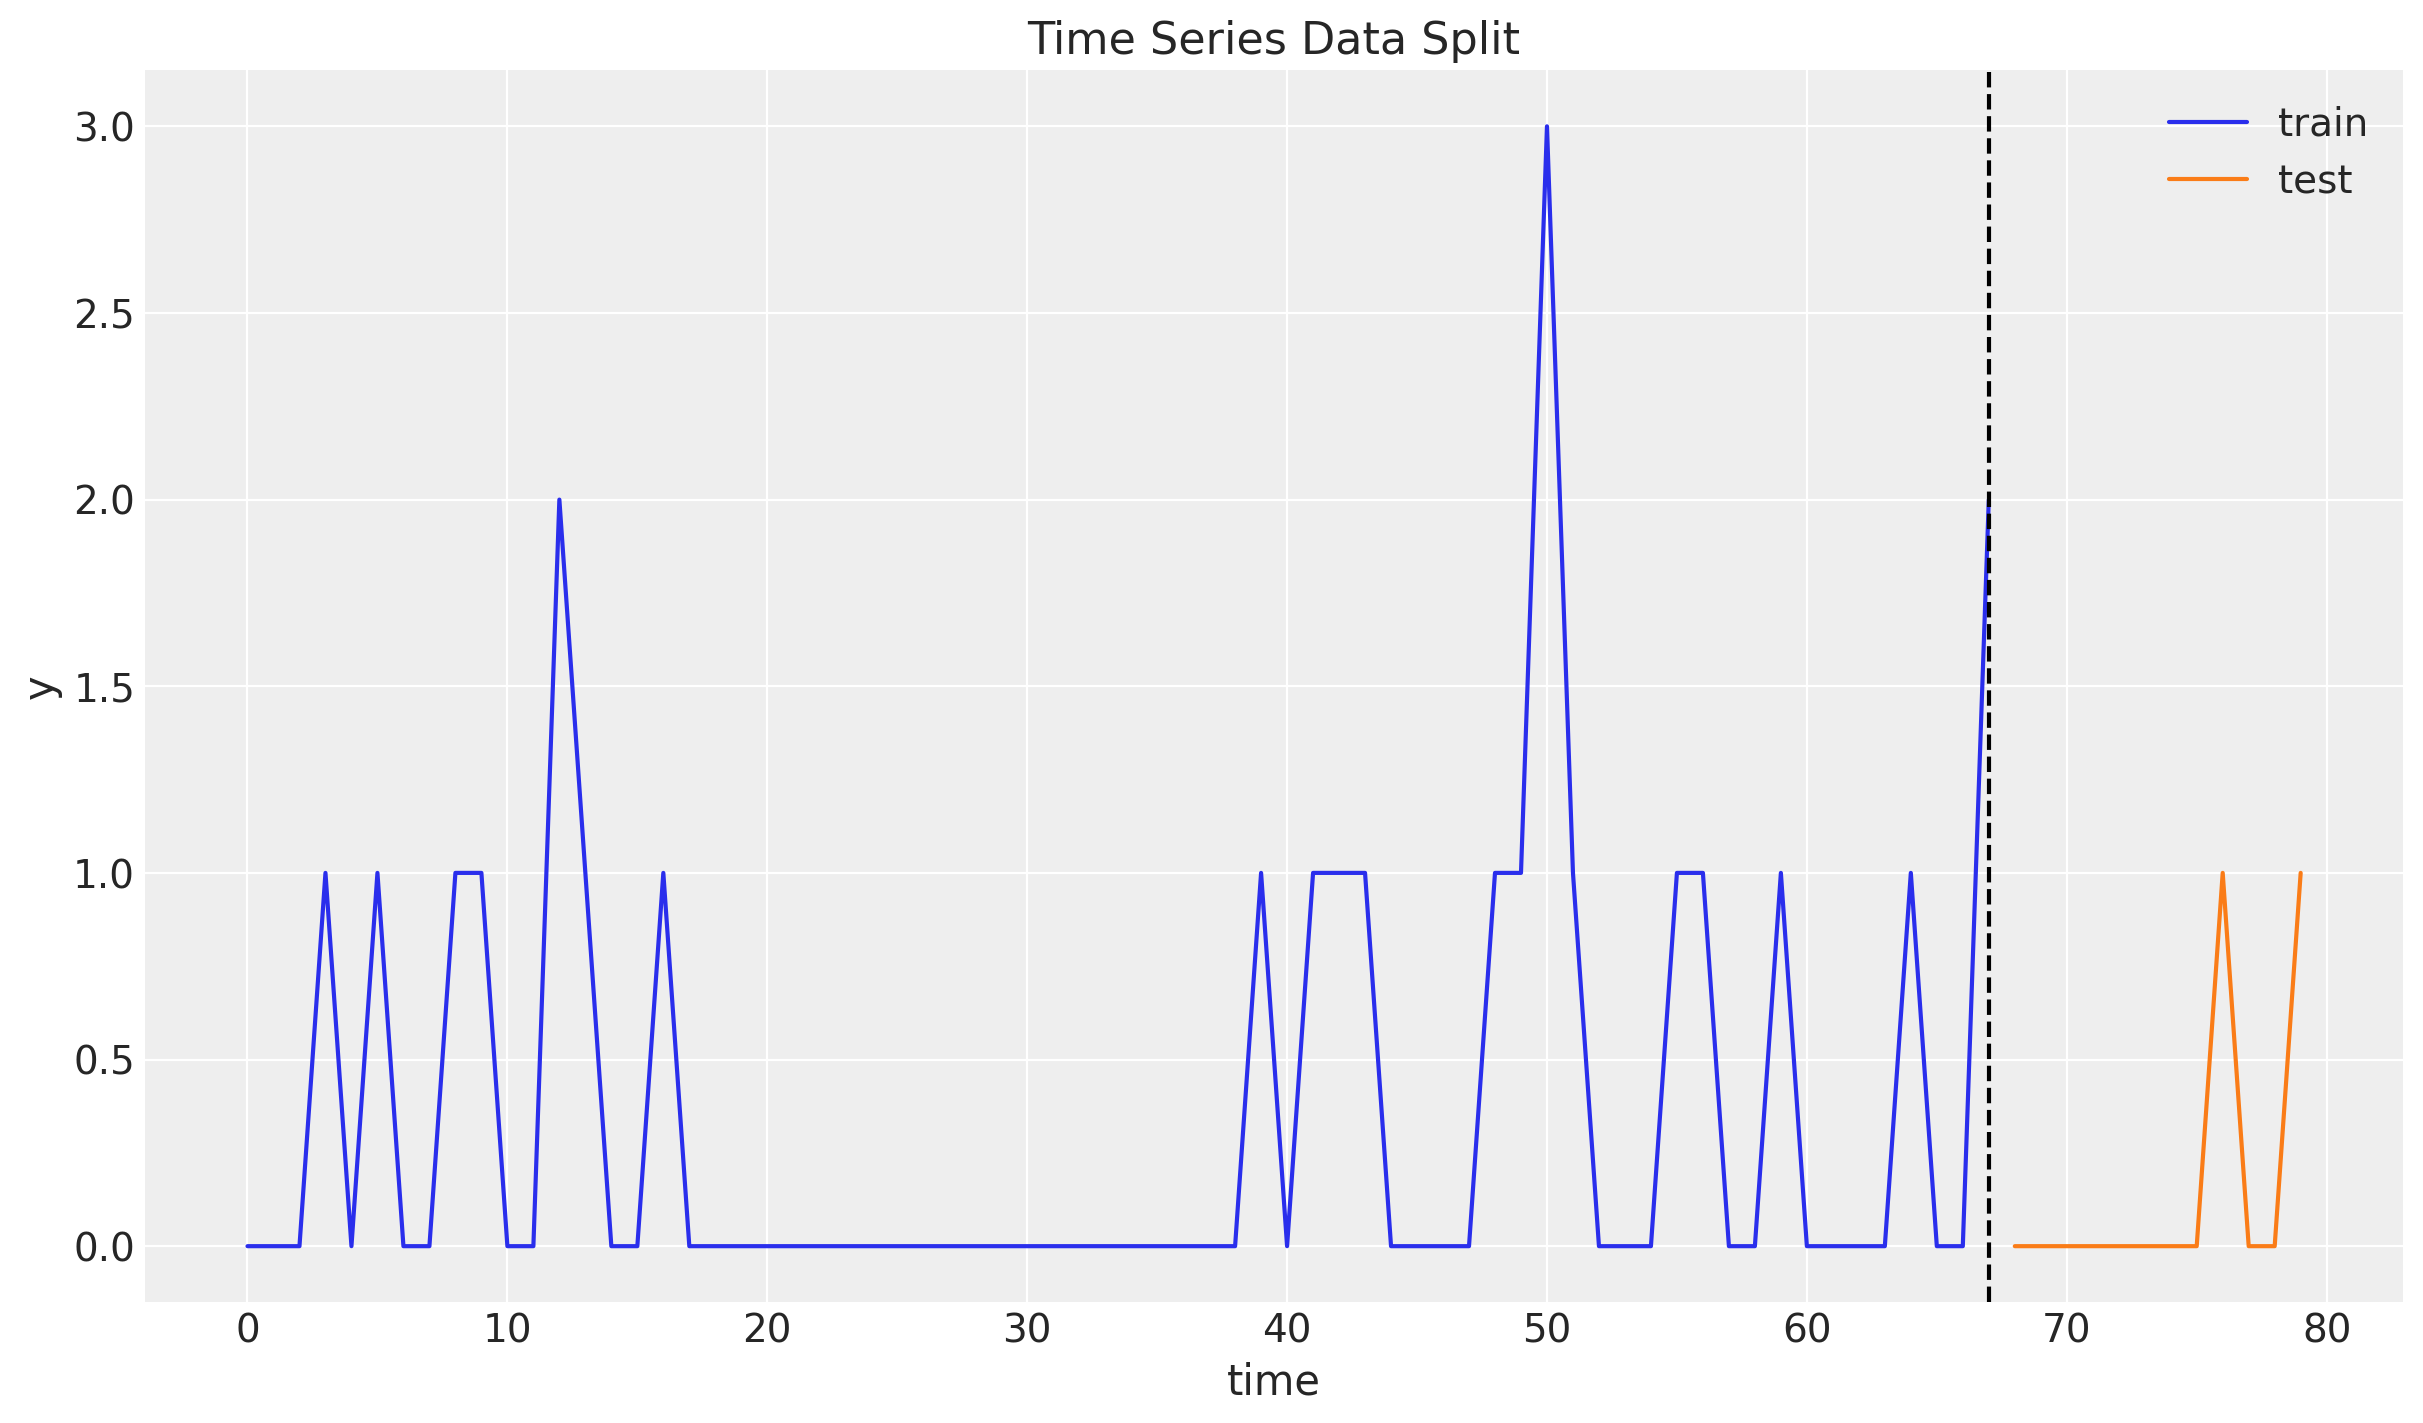

In [3]:
n = y.size

prop_train = 0.85
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

## Idea of Croston's Method

As mentioned earlier, Croston's method is based on the idea of separating the original series $y_{t}$ into the demand size and the demand interval.

- To generate the demand size time series $z_{t}$ we simply keep the non-zero values of the original series.

- To generate the demand interval time series $y_{t}$ we keep the time between non-zero values of the original series.

Lets see how we can do this:

In [4]:
# Demand time series
z = y_train[y_train != 0]

print(f"Demand: {z}")

# Demand intervals (periods)
p_idx = jnp.flatnonzero(y_train).astype(jnp.float32)
p = jnp.diff(p_idx, prepend=-1)

print("Period, p: ", p)

Demand: [1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 2.]
Period, p:  [ 4.  2.  3.  1.  3.  1.  3. 23.  2.  1.  1.  5.  1.  1.  1.  4.  1.  3.
  5.  3.]


We can visualize the demand size and demand interval time series (note they have the same length!):

Text(0.5, 1.0, 'Period')

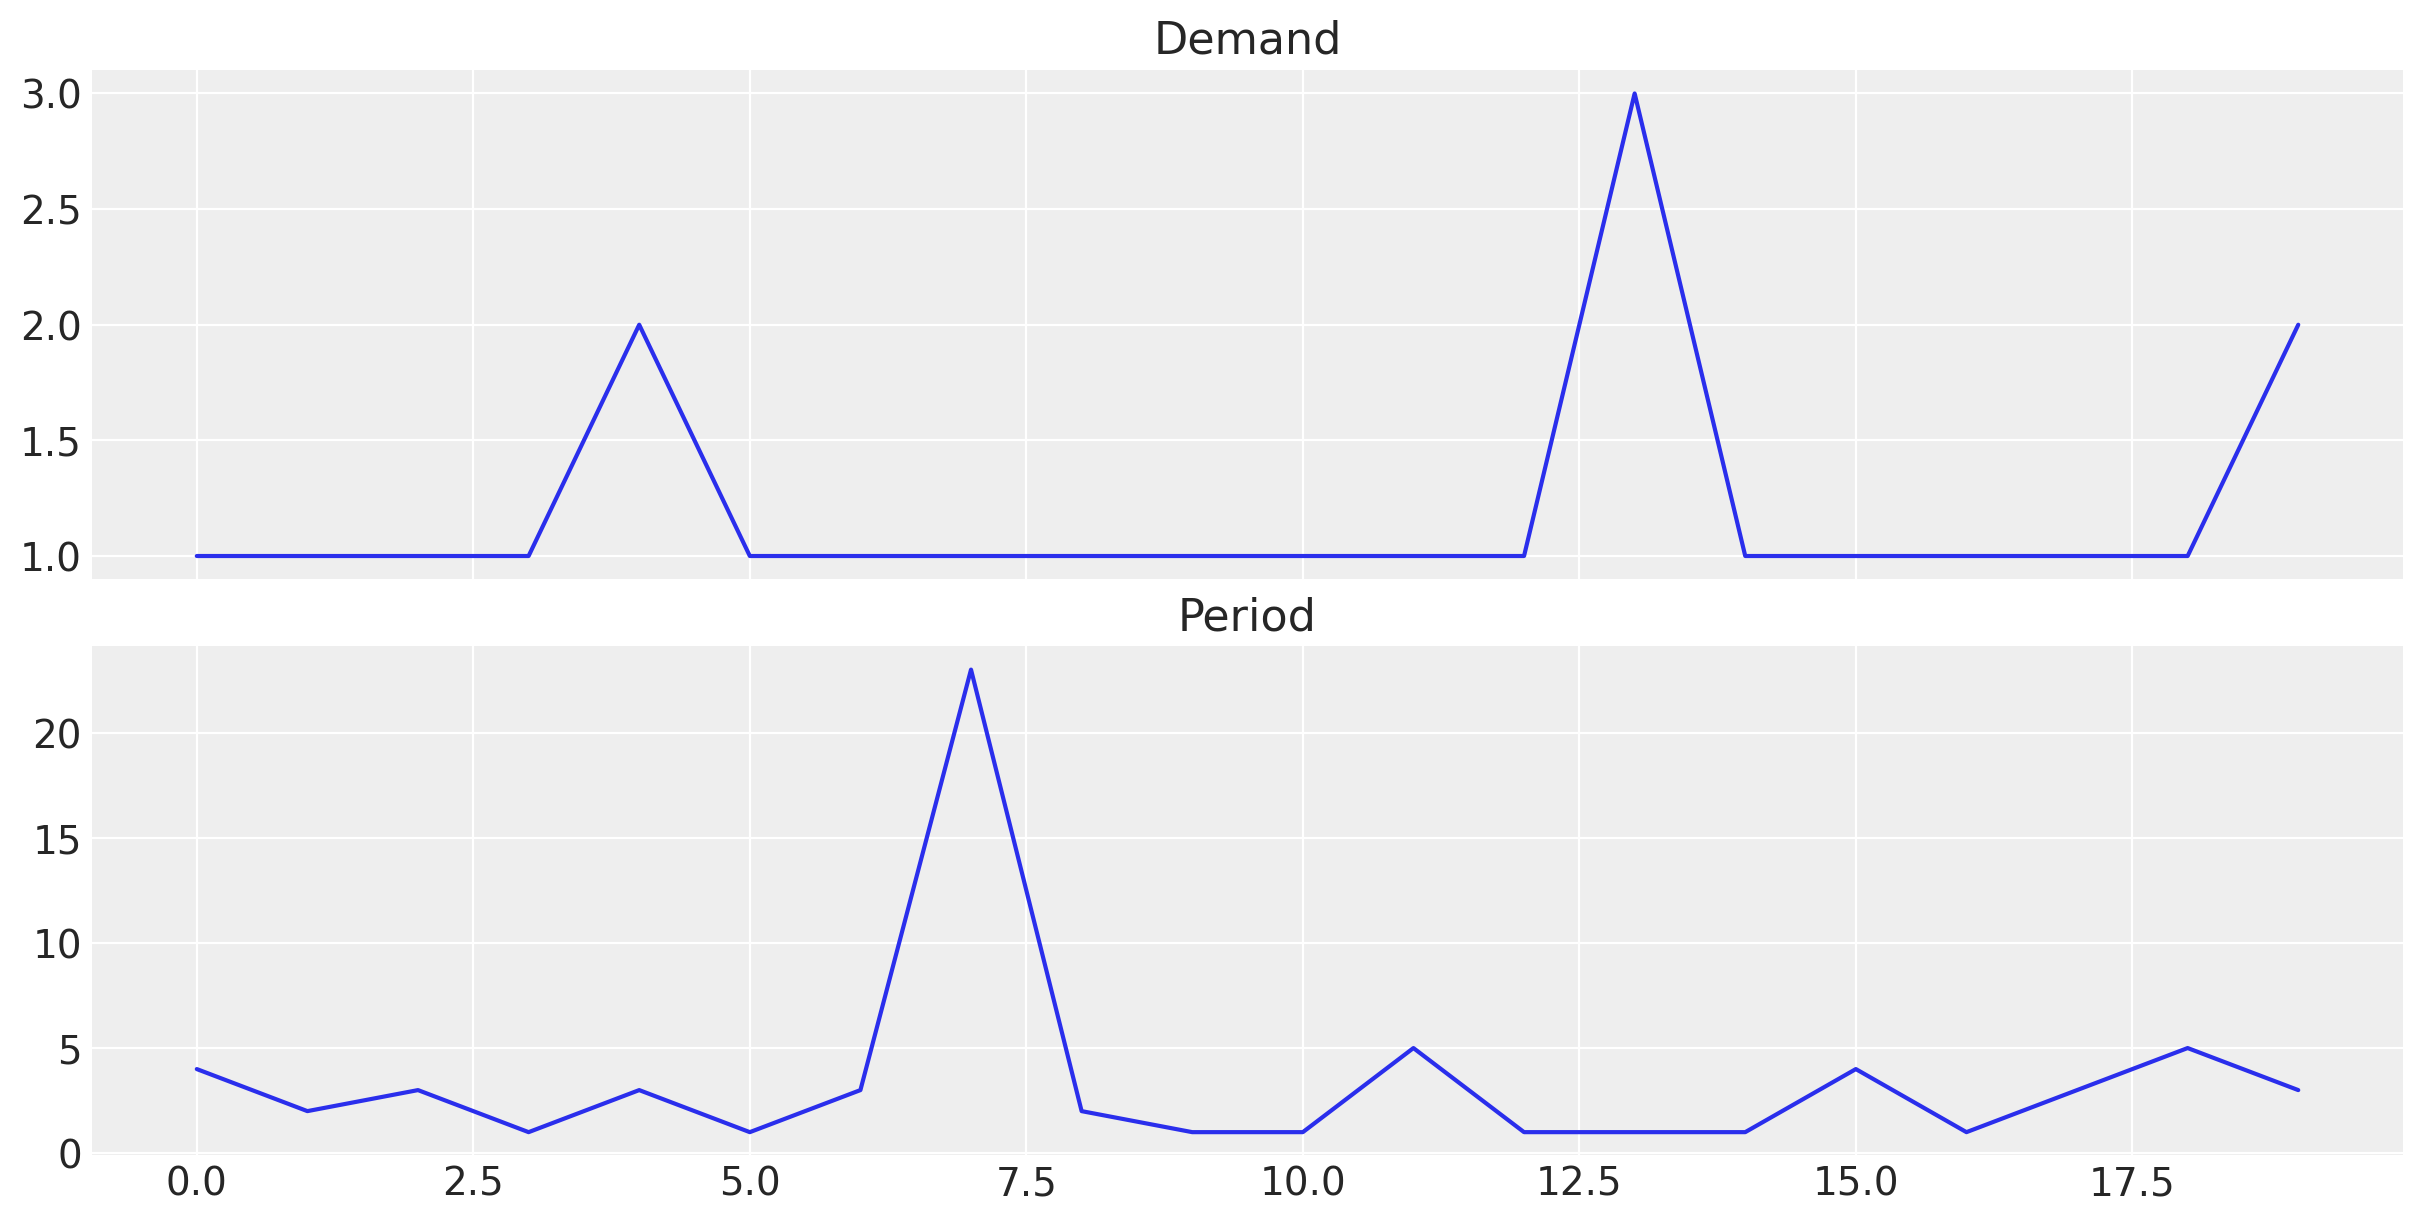

In [5]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 6), sharex=True, sharey=False, layout="constrained"
)
ax[0].plot(z)
ax[0].set_title("Demand")
ax[1].plot(p)
ax[1].set_title("Period")

Once we have the demand size and demand interval time series, we can use simple exponential smoothing to forecast them. We can then combine the forecasts to get the final forecast as 

$$\hat{y}_{t+h} = \frac{\hat{z}_{t}}{\hat{p}_{t}}$$

**Remarks [Smoothing Parameter]:**
- In the original Croston's method, the smoothing parameters of both series is set to the same value. However, we can also estimate the smoothing parameters separately (Croston Optimized). We will use the latter approach in this notebook.
- In principle, the smoothing parameter can take any value between 0 and 1. However, in practice, we often restrict it to a value closer to zero than to one. The reason being that for values closer to one, the forecast is more influenced by recent demand values which leads to a more volatile forecast.

## Croston's Method with StatsForecast

Before we implement Croston's method from scratch, we use the [`statsforecast`](https://nixtlaverse.nixtla.io/statsforecast/index.html) where there are many time series methods implemented. We use the [`CrostonOptimized`](https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#crostonoptimized) object to generate the forecast. From the documentation:

> *A variation of the classic Croston’s method where the smooting paramater is optimally selected from the range $[0.1, 0.3]$. Both the non-zero demand $z_{t}$ and the inter-demand intervals $p_{t}$ are smoothed separately, so their smoothing parameters can be different.*

We use conformal prediction intervals to generate prediction intervals for the forecast.

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Croston Optimized Forecast (StatsForecast)')]

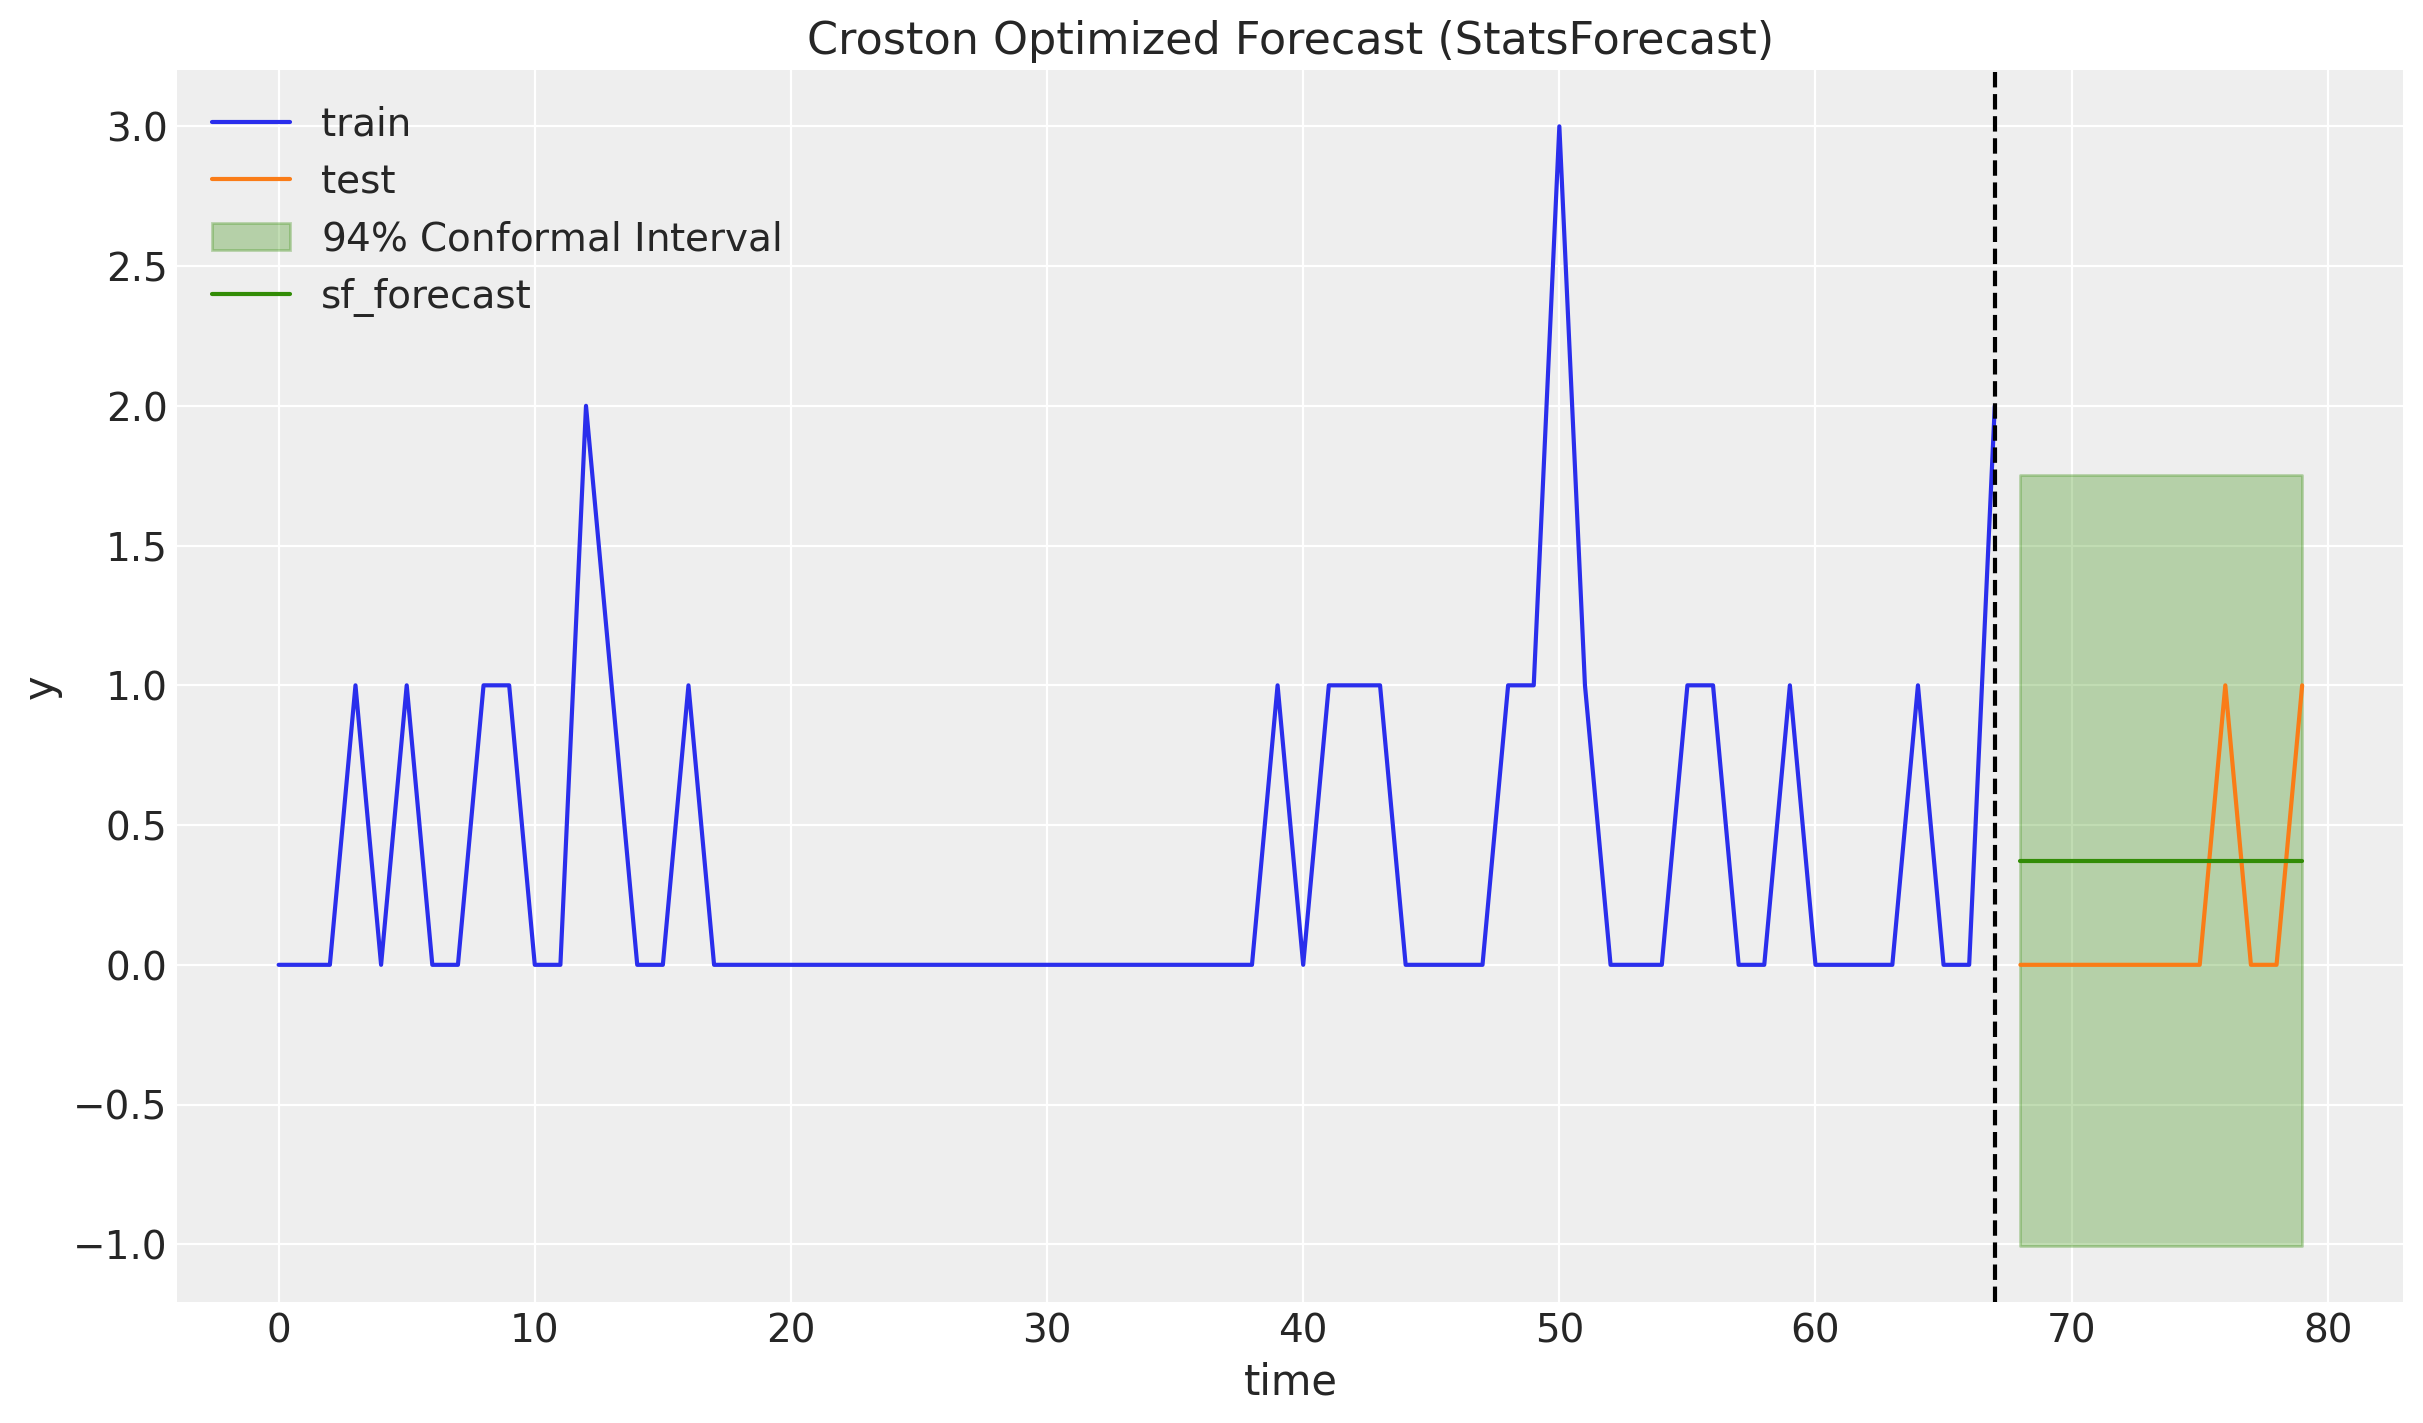

In [6]:
sf = StatsForecast(
    models=[CrostonOptimized()],
    freq=1,
    n_jobs=-1,
)

train_df = pd.DataFrame({"unique_id": "a", "ds": t_train, "y": y_train})

sf_forecast = sf.forecast(
    h=y_test.size,
    df=train_df,
    level=[94],
    prediction_intervals=ConformalIntervals(n_windows=5),
)


fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.fill_between(
    t_test,
    sf_forecast["CrostonOptimized-lo-94"],
    sf_forecast["CrostonOptimized-hi-94"],
    color="C2",
    alpha=0.3,
    label="$94\\%$ Conformal Interval",
)
ax.plot(t_test, sf_forecast["CrostonOptimized"], color="C2", label="sf_forecast")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Croston Optimized Forecast (StatsForecast)")

It is a bit weird that the conformal intervals cover a lot of negative values (it is symmetric around the point forecast). It would be nice to have a model that can generate prediction intervals that are always positive.

## Croston's Method in NumPyro

As described in the introduction, we can use the simple exponential smoothing (level) model presented in the previous post [Notes on Exponential Smoothing with NumPyro](https://juanitorduz.github.io/exponential_smoothing_numpyro/). The only thing we need to change is to select a prior for the smoothing parameter so that the support of the prior is close to the interval $[0.1, 0.3]$. As we are using a Beta distribution as a prior for the smoothing parameter, we can use a Beta distribution with parameters $\alpha = 10$ and $\beta = 40$.

[Text(0.5, 1.0, 'Beta(10, 40) PDF'), Text(0.5, 0, '$\\alpha$')]

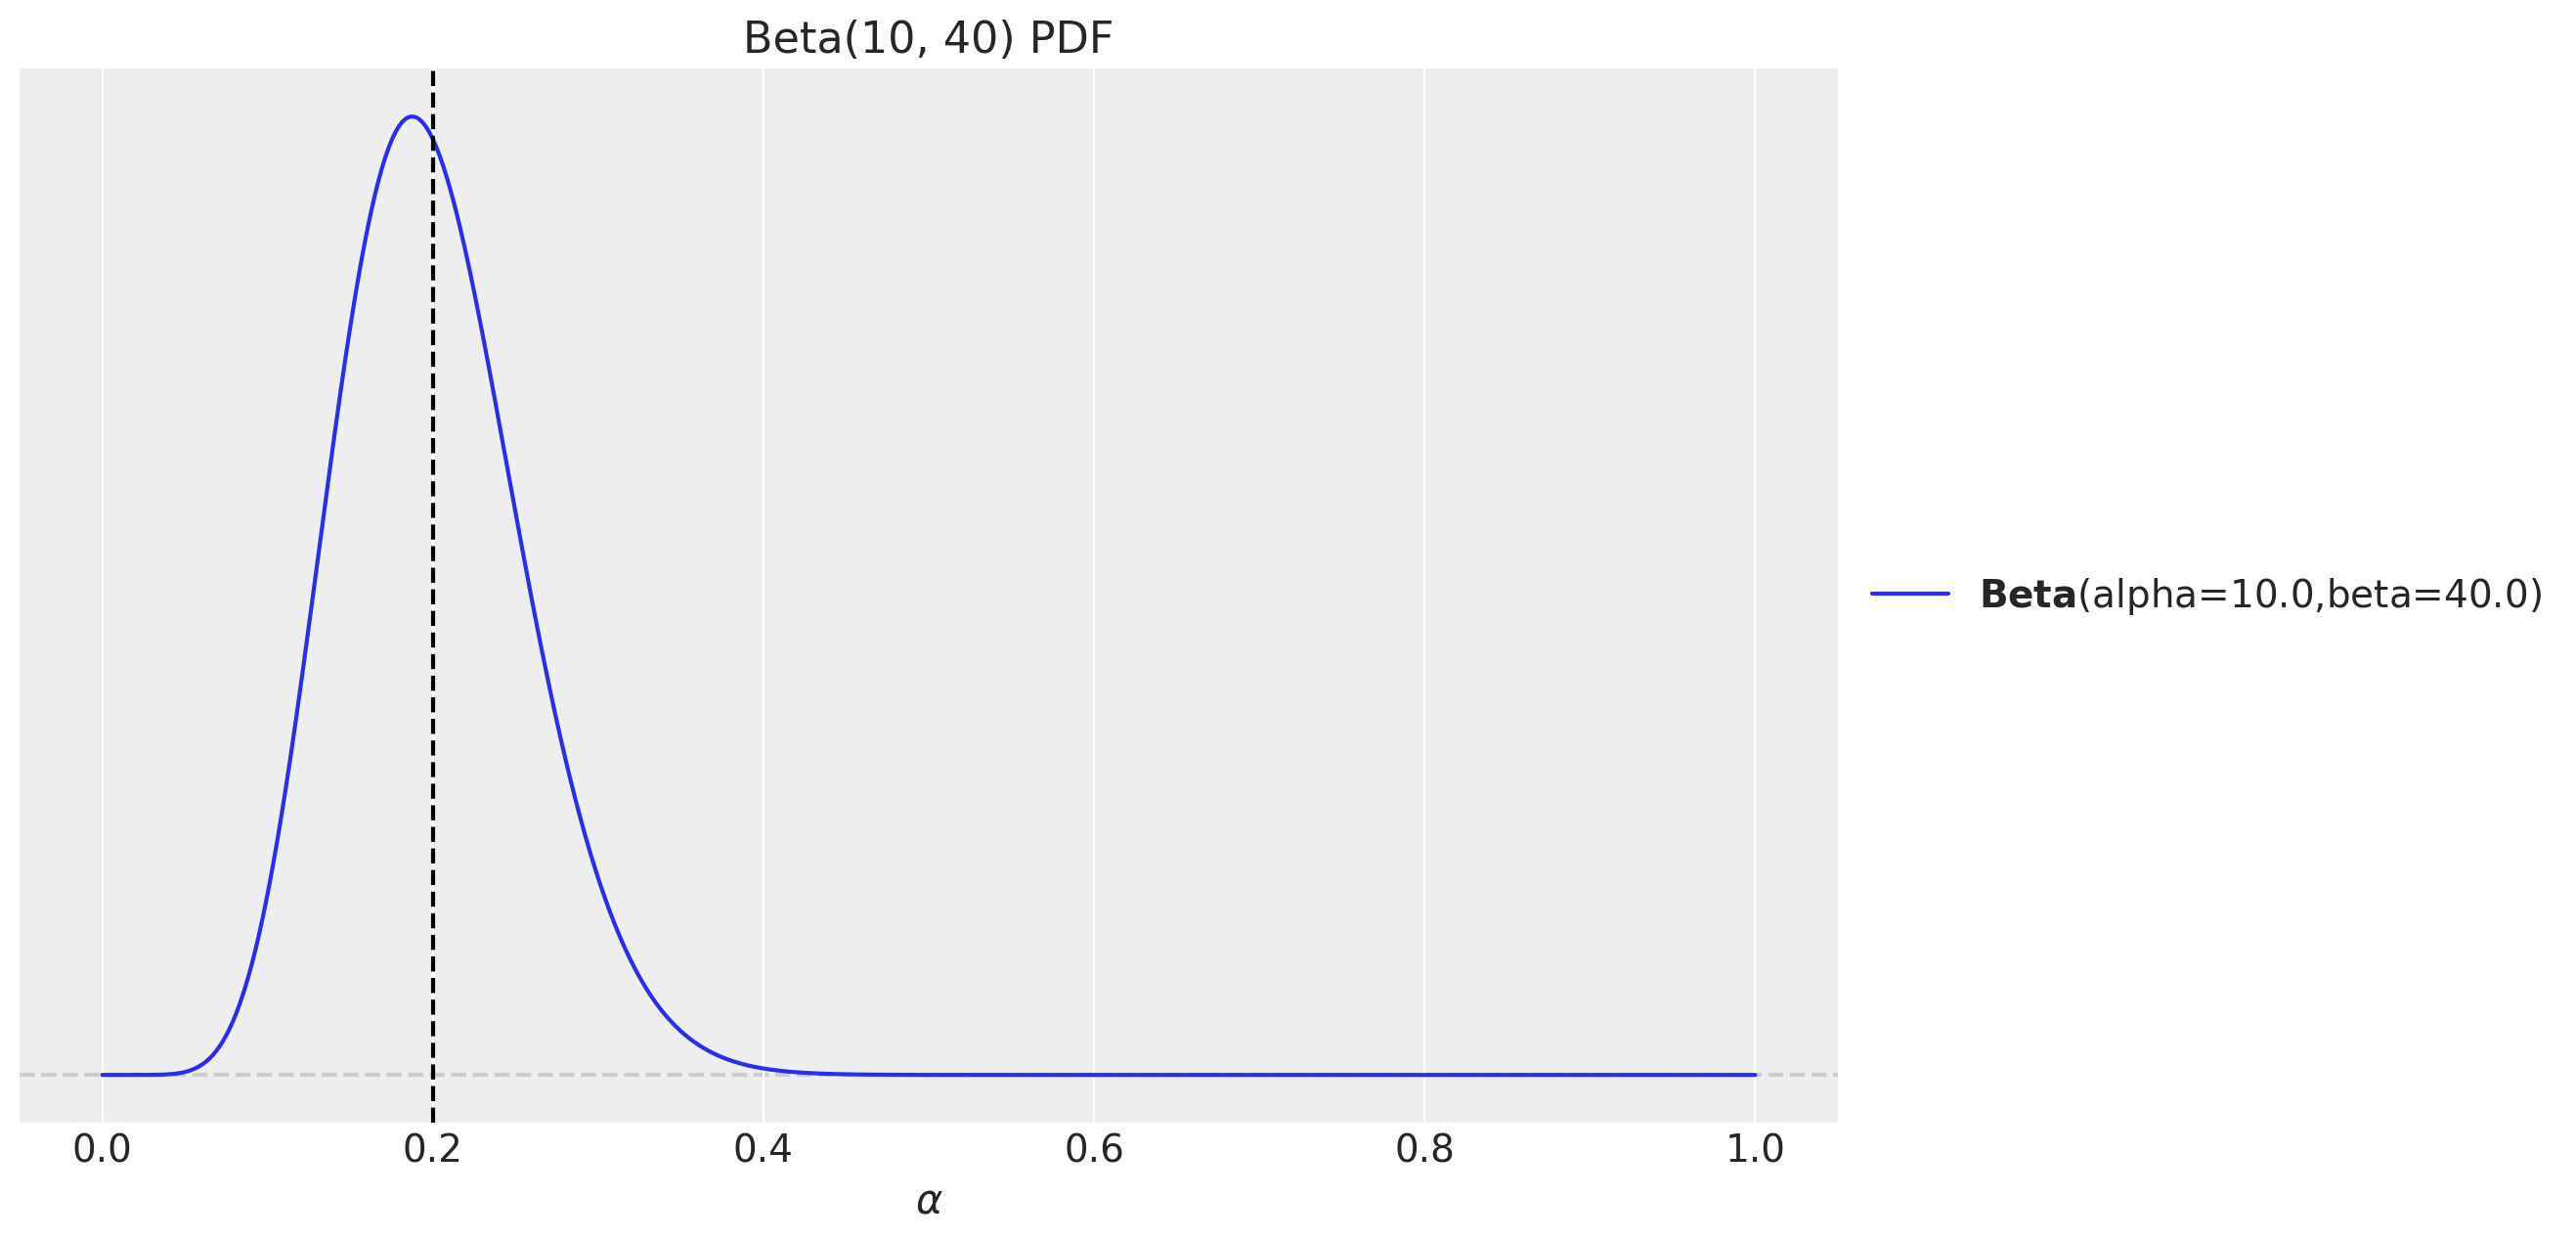

In [7]:
fig, ax = plt.subplots()
pz.Beta(10, 40).plot_pdf(ax=ax)
ax.axvline(x=(10 / (40 + 10)), c="black", linestyle="--")  # mean
ax.set(title="Beta(10, 40) PDF", xlabel="$\\alpha$")

Recall the model structure for the simple exponential smoothing (level) model:

In [8]:
def level_model(ts: ArrayImpl, future: int = 0) -> None:
    t_max = ts.size

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample(
        "level_smoothing", dist.Beta(concentration1=2, concentration0=20)
    )
    level_init = numpyro.sample("level_init", dist.Normal(loc=0, scale=1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * y[t] + (1 - level_smoothing) * previous_level,
            previous_level,
        )

        mu = previous_level
        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        return level, pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": ts}):
        _, preds = scan(
            transition_fn,
            level_init,
            jnp.arange(t_max + future),
        )

    # --- Forecast ---

    if future > 0:
        return numpyro.deterministic("ts_forecast", preds[-future:])
    return None

**Remark**: Taking the quotient of two posterior distribution samples which can be very close to zero brings numerical instability. Hence, we model the inverse of the periods instead of the periods themselves. This way, we can take the product of the demand size and the inverse of the periods to get the forecast.

In [9]:
p_inv = 1 / p

We need an auxiliary function combine the forecasts.

In [10]:
def croston_model(z: ArrayImpl, p_inv: ArrayImpl, future: int = 0) -> None:
    z_forecast = scope(level_model, "demand")(z, future)
    p_inv_forecast = scope(level_model, "period_inv")(p_inv, future)

    if future > 0:
        numpyro.deterministic("z_forecast", z_forecast)
        numpyro.deterministic("p_inv_forecast", p_inv_forecast)
        numpyro.deterministic("forecast", z_forecast * p_inv_forecast)

Note that we can use the [`scope`](https://num.pyro.ai/en/stable/handlers.html#scope) effect handler to reuse the same model for the demand size and the demand interval.

### Inference

We now fit the model:

In [11]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [12]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, croston_model, inference_params, z, p_inv)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [13]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
demand/level_init,1.348,0.195,0.985,1.710,0.002,0.002,7094.0,5060.0,1.0
demand/level_smoothing,0.029,0.020,0.002,0.065,0.000,0.000,6165.0,4928.0,1.0
demand/noise,0.594,0.108,0.418,0.803,0.001,0.001,8106.0,5338.0,1.0
period_inv/level_init,0.645,0.166,0.324,0.956,0.002,0.002,6946.0,5112.0,1.0
period_inv/level_smoothing,0.084,0.055,0.003,0.182,0.001,0.000,6785.0,4405.0,1.0
period_inv/noise,0.399,0.070,0.278,0.527,0.001,0.001,9086.0,4615.0,1.0


In [14]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


The model seems to be fitting well. Let's look into the trace:

Text(0.5, 0.98, 'Croston Model Trace')

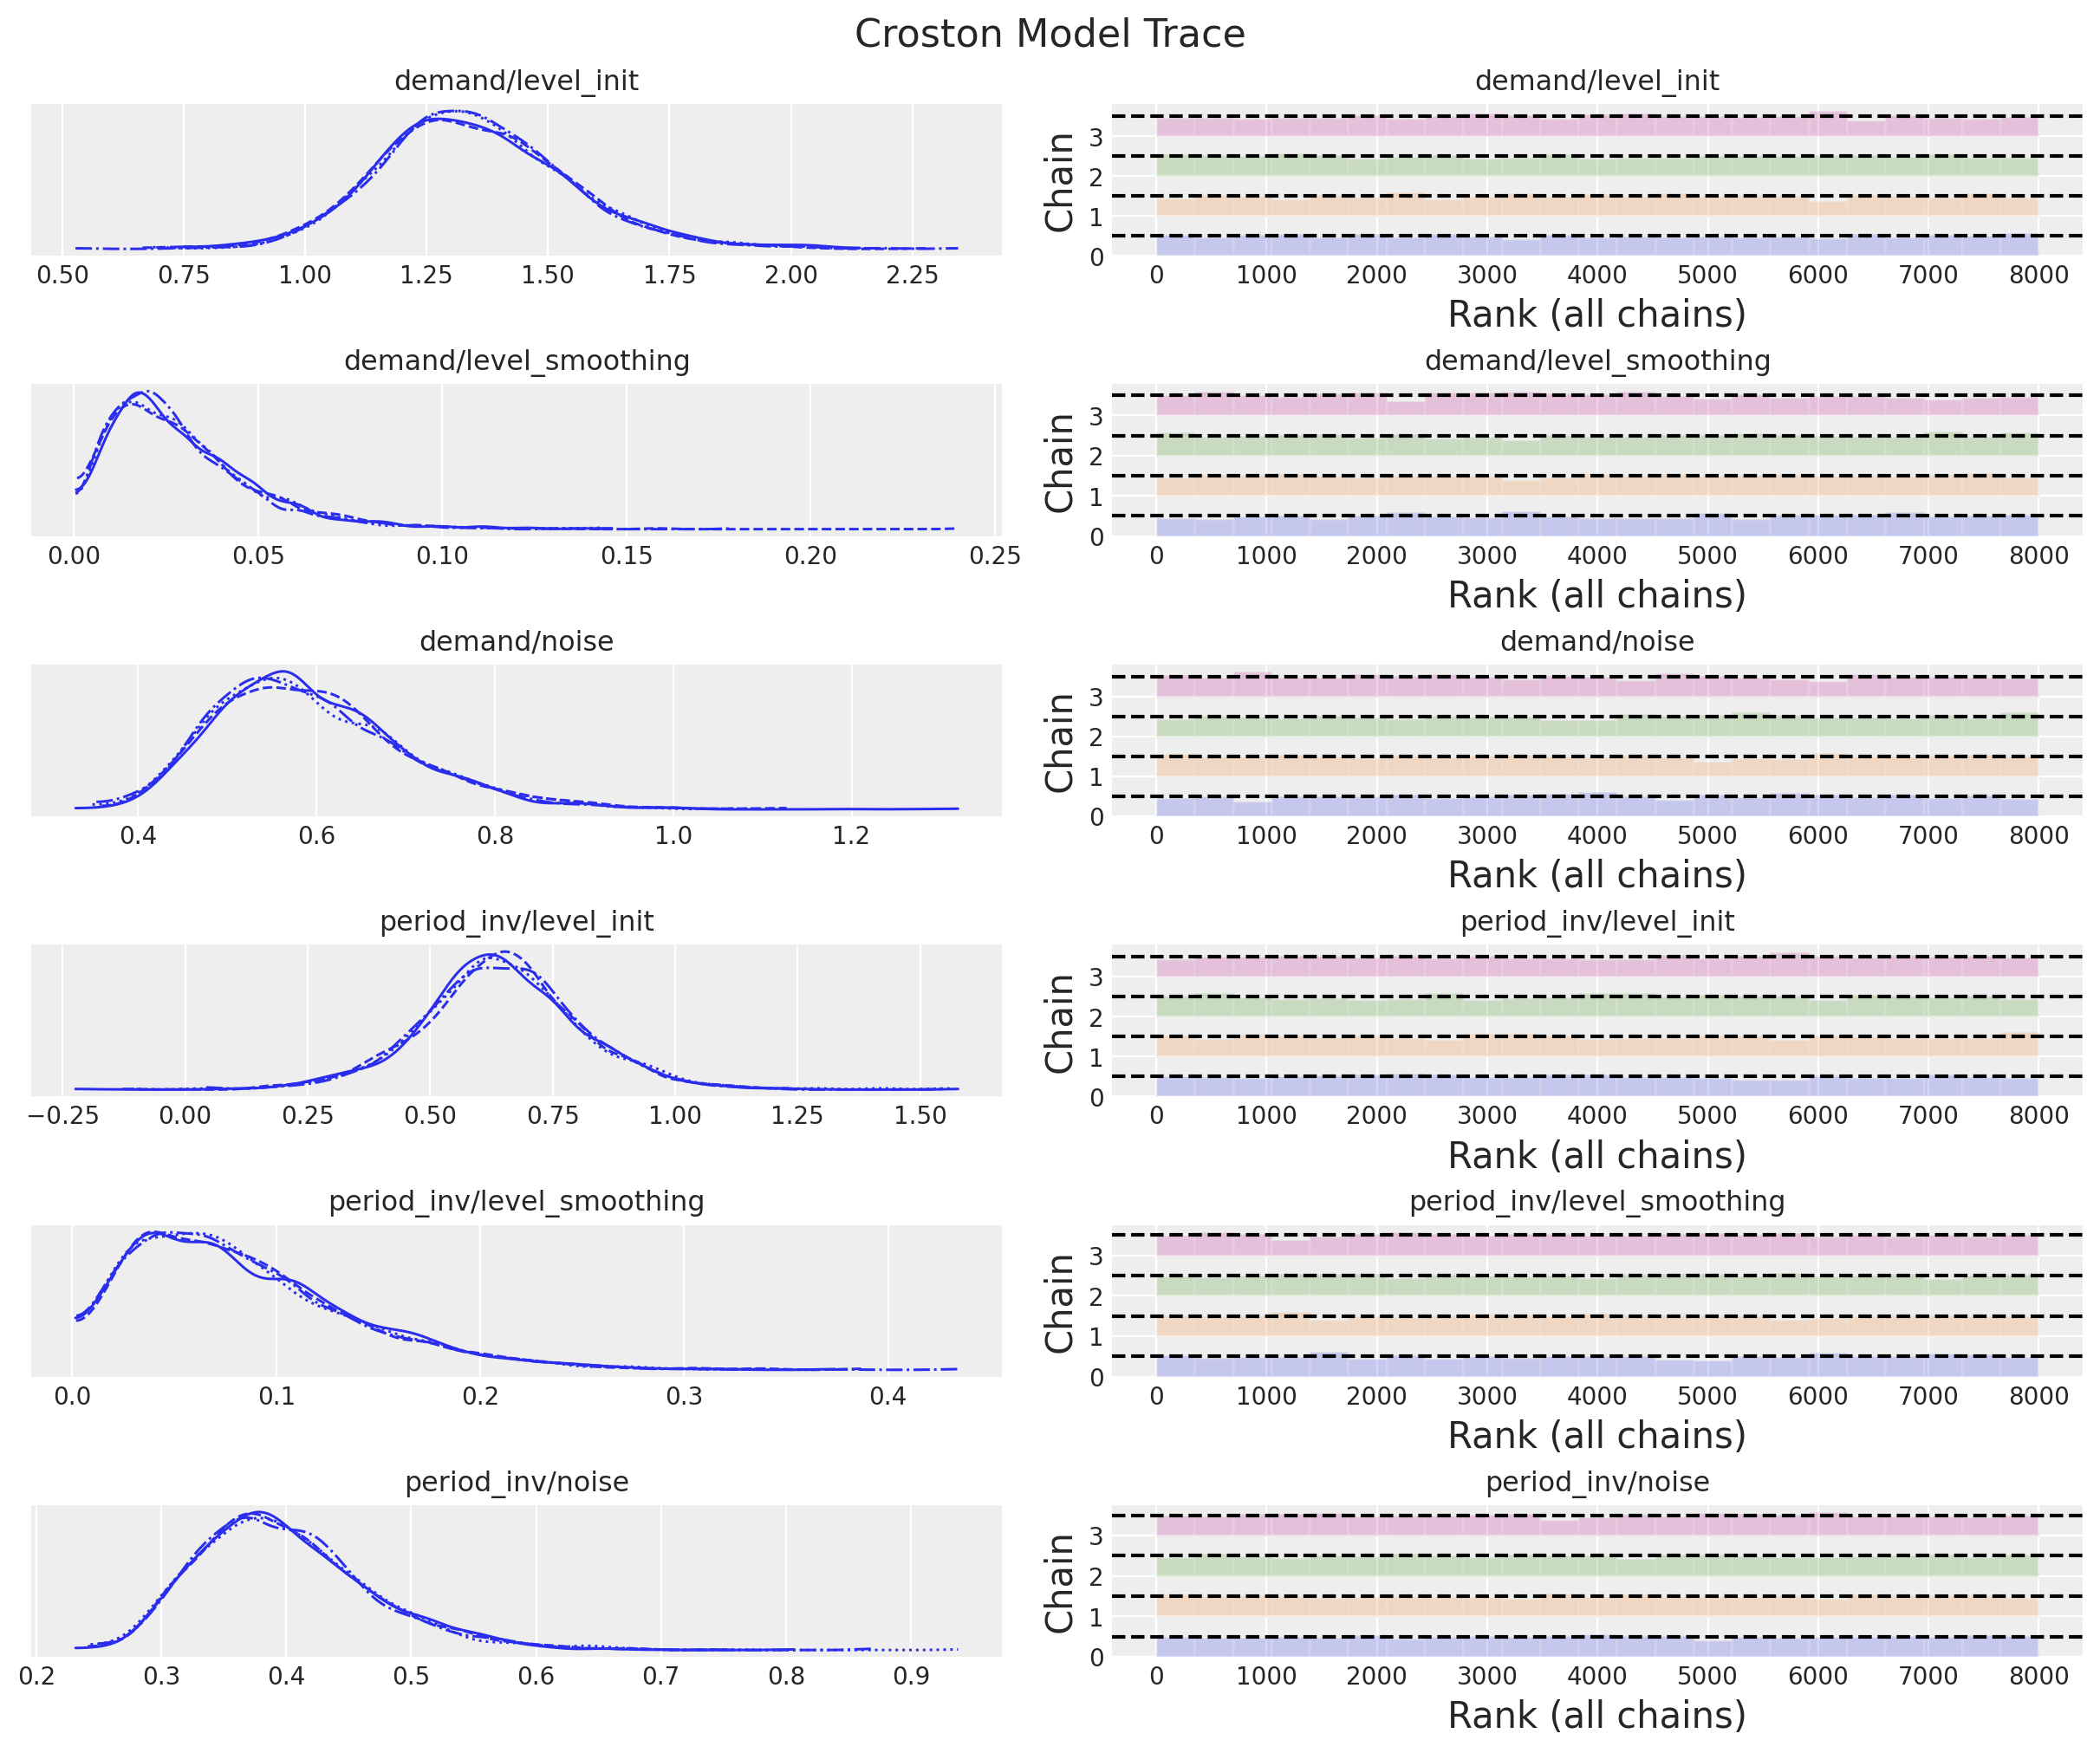

In [15]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Croston Model Trace", fontsize=16)

It is worth noting that the posterior distribution of the smoothing parameters between the demand size and the demand interval are different.

### Forecast

We now generate the forecast:

In [16]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["z_forecast", "p_inv_forecast", "forecast"],
    )
    return predictive(rng_key, *model_args)

In [17]:
rng_key, rng_subkey = random.split(key=rng_key)
croston_forecast = forecast(
    rng_subkey, croston_model, mcmc.get_samples(), z, p_inv, y_test.size
)

In [18]:
posterior_predictive = az.from_numpyro(
    posterior_predictive=croston_forecast,
    coords={"t": t_test},
    dims={"z_forecast": ["t"], "p_inv_forecast": ["t"], "forecast": ["t"]},
)

First, let us look into the forecast for each component:

Text(0.5, 1.0, 'Period')

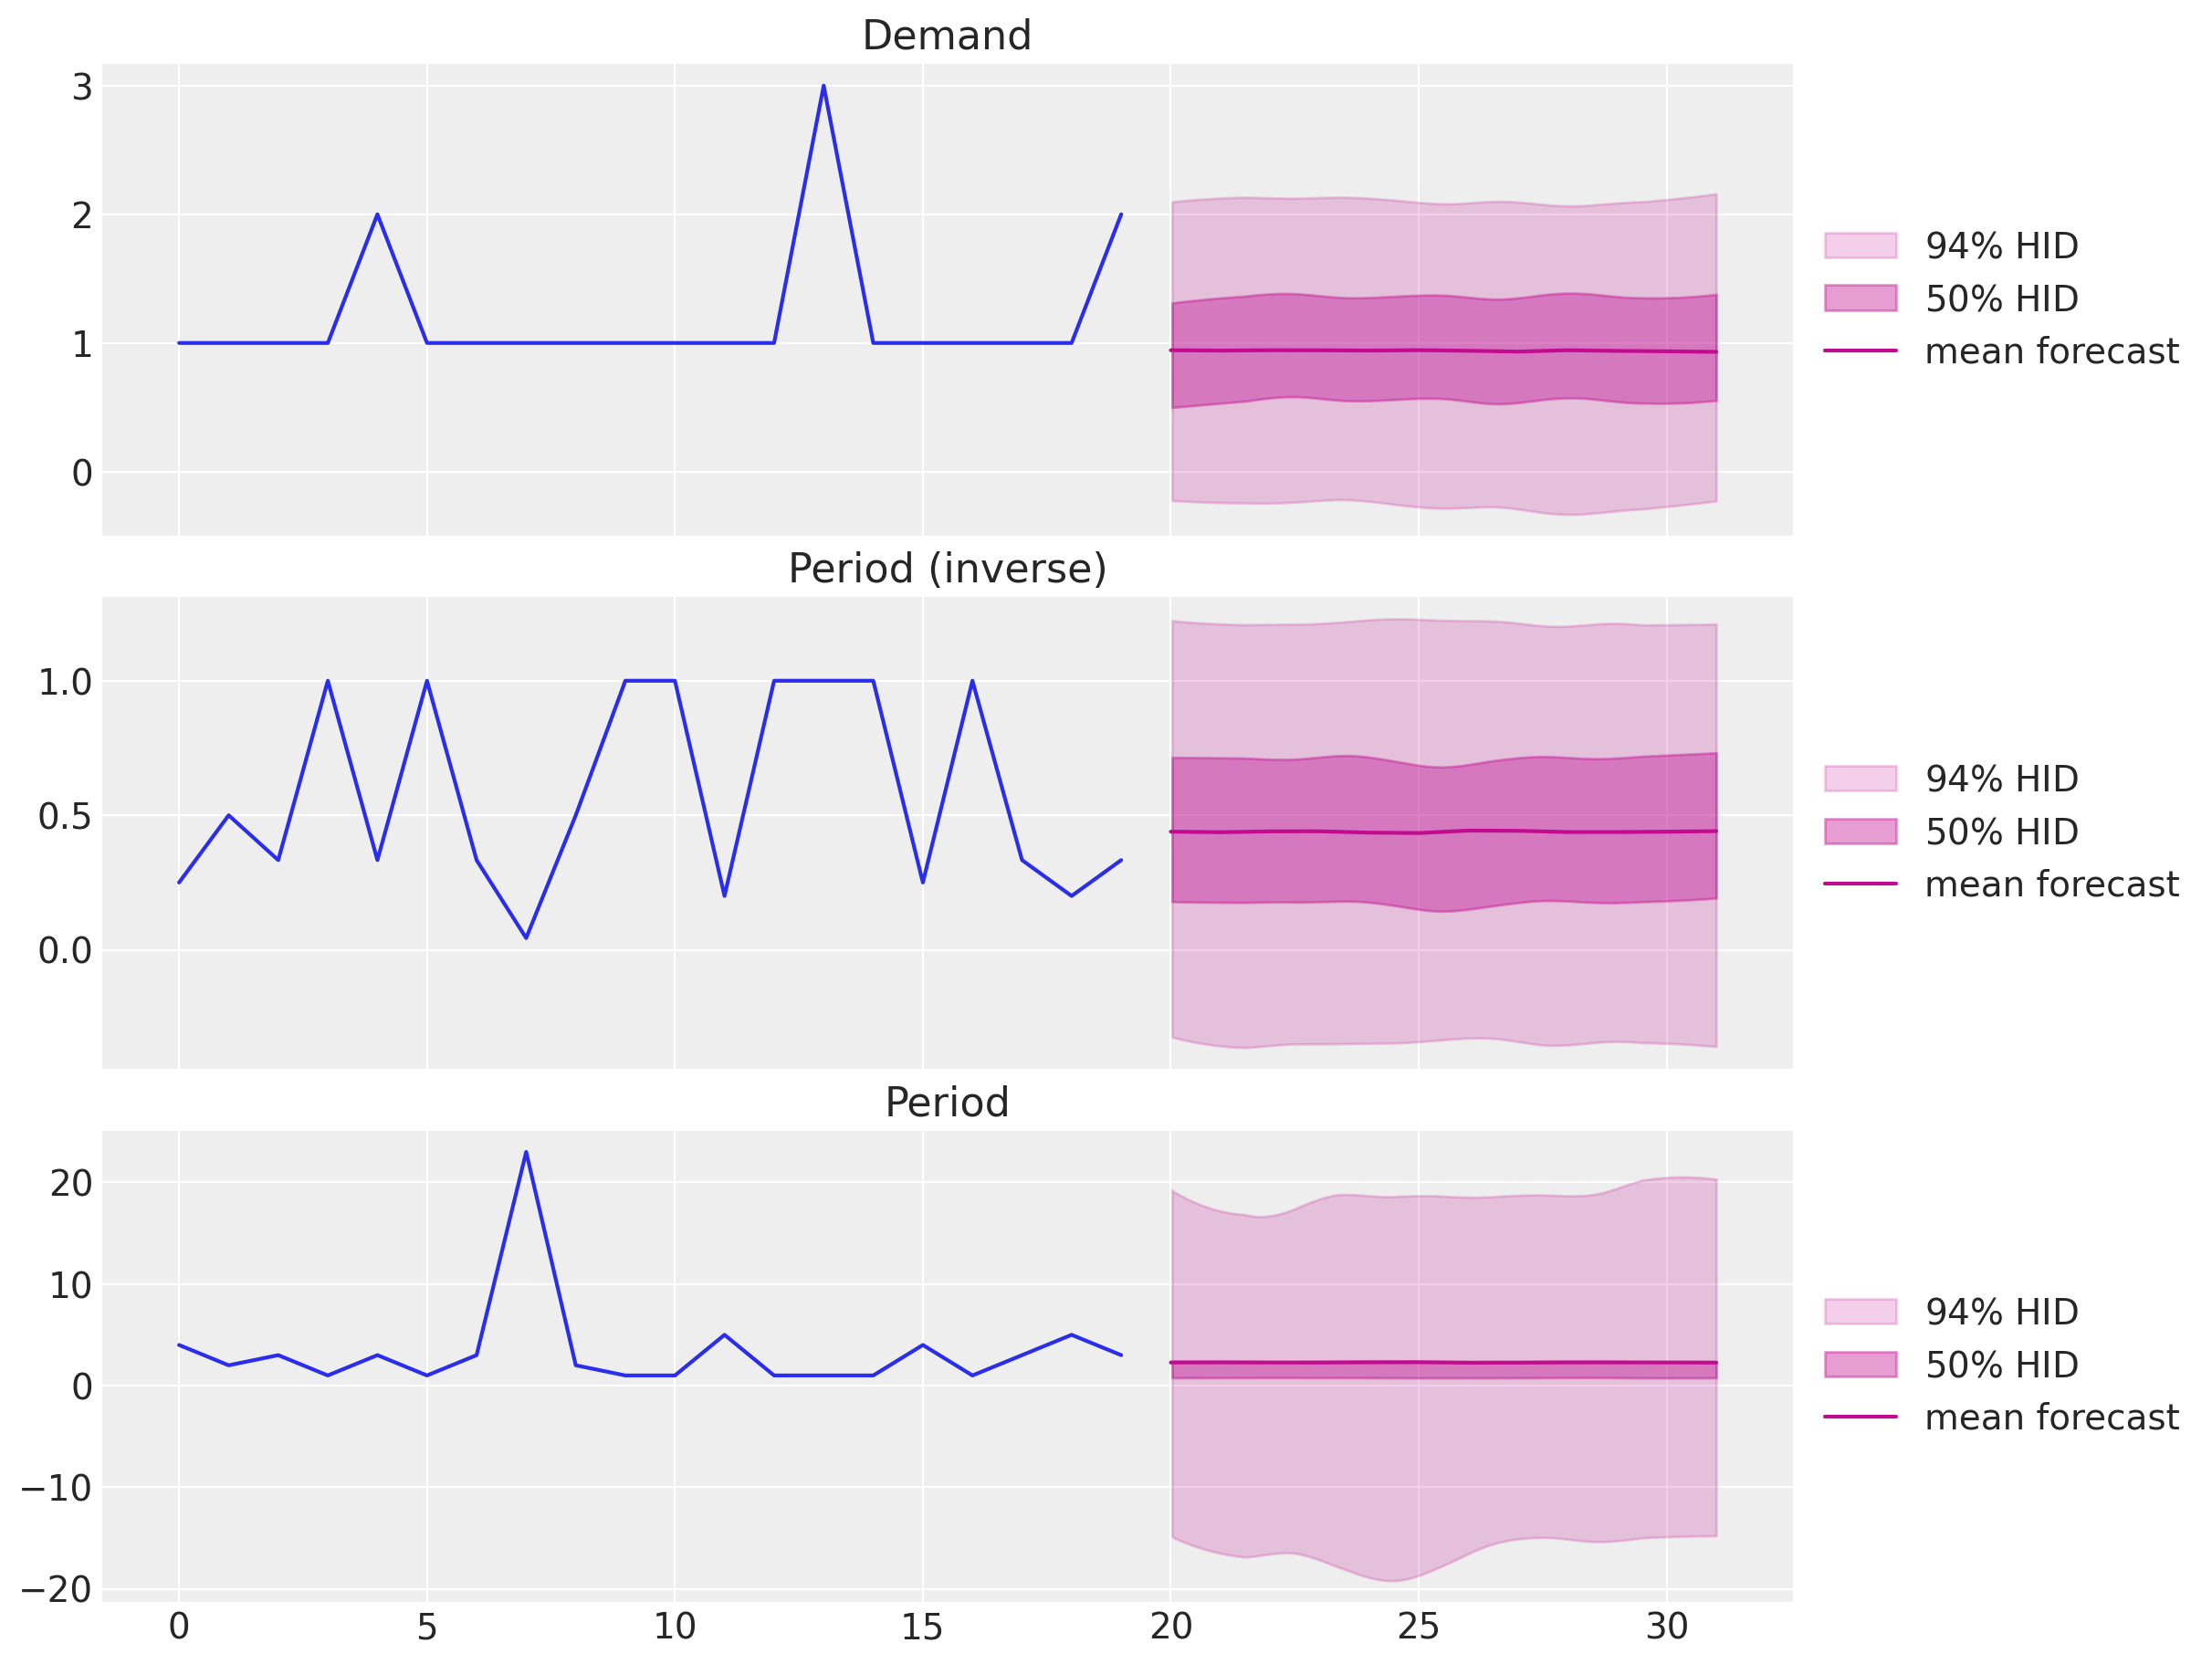

In [19]:
fig, ax = plt.subplots(
    nrows=3, ncols=1, figsize=(12, 9), sharex=True, sharey=False, layout="constrained"
)
ax[0].plot(z)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["z_forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HID"},
    ax=ax[0],
)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["z_forecast"],
    hdi_prob=0.5,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": r"$50\%$ HID"},
    ax=ax[0],
)
ax[0].plot(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["z_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set_title("Demand")

ax[1].plot(1 / p)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["p_inv_forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HID"},
    ax=ax[1],
)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["p_inv_forecast"],
    hdi_prob=0.5,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": r"$50\%$ HID"},
    ax=ax[1],
)
ax[1].plot(
    range(z.size, z.size + y_test.size),
    posterior_predictive["posterior_predictive"]["p_inv_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set_title("Period (inverse)")

ax[2].plot(p)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    1 / posterior_predictive["posterior_predictive"]["p_inv_forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HID"},
    ax=ax[2],
)
az.plot_hdi(
    range(z.size, z.size + y_test.size),
    1 / posterior_predictive["posterior_predictive"]["p_inv_forecast"],
    hdi_prob=0.5,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HID"},
    ax=ax[2],
)
ax[2].plot(
    range(z.size, z.size + y_test.size),
    1
    / posterior_predictive["posterior_predictive"]["p_inv_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax[2].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[2].set_title("Period")

We can combine the forecasts to get the final result:

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Croston Model Forecast')]

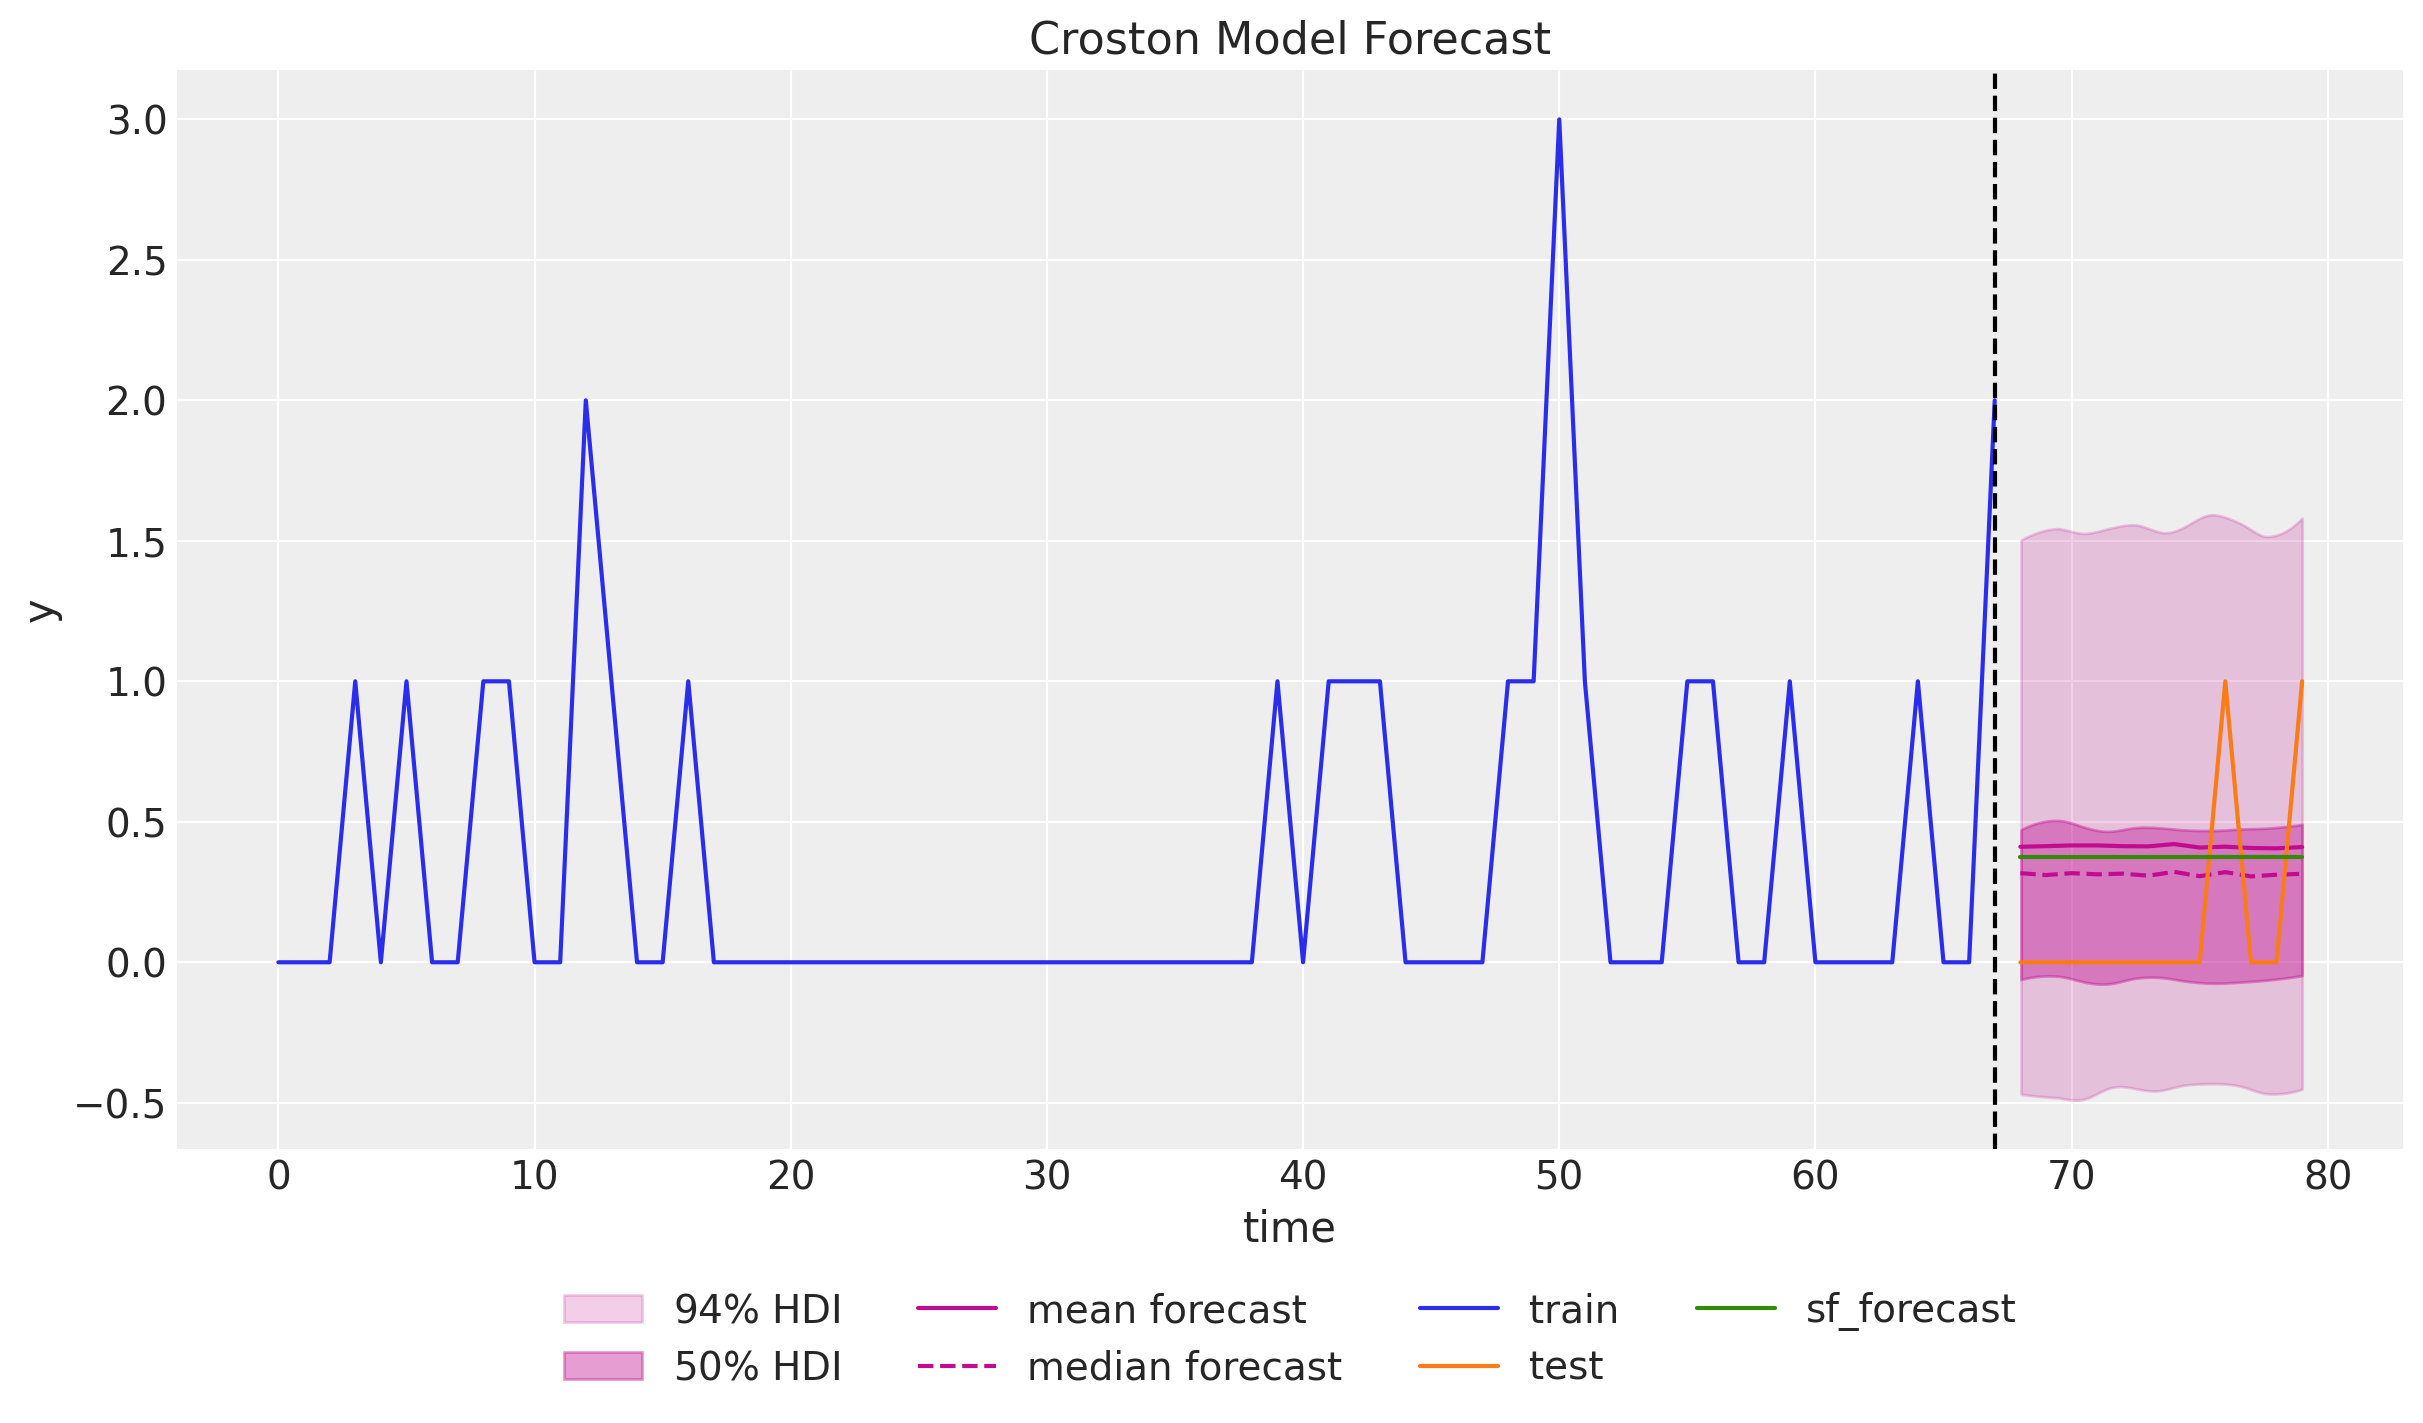

In [20]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["forecast"],
    hdi_prob=0.50,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["forecast"].median(
        dim=("chain", "draw")
    ),
    color="C3",
    linestyle="--",
    label="median forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.plot(t_test, sf_forecast["CrostonOptimized"], color="C2", label="sf_forecast")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="time", ylabel="y", title="Croston Model Forecast")

- It is interesting to see that the forecast generated by the `statsforecast` package lies in between the mean and the median of the posterior predictive distribution. There seems to be some skewness in the posterior distribution. 
- Note that the credible intervals are narrower than the conformal intervals generated by the `statsforecast` package.Moreover, they over less negative values.

Finally, we can plot the posterior distribution of the forecast as a density:

<Axes: title={'center': 'forecast'}>

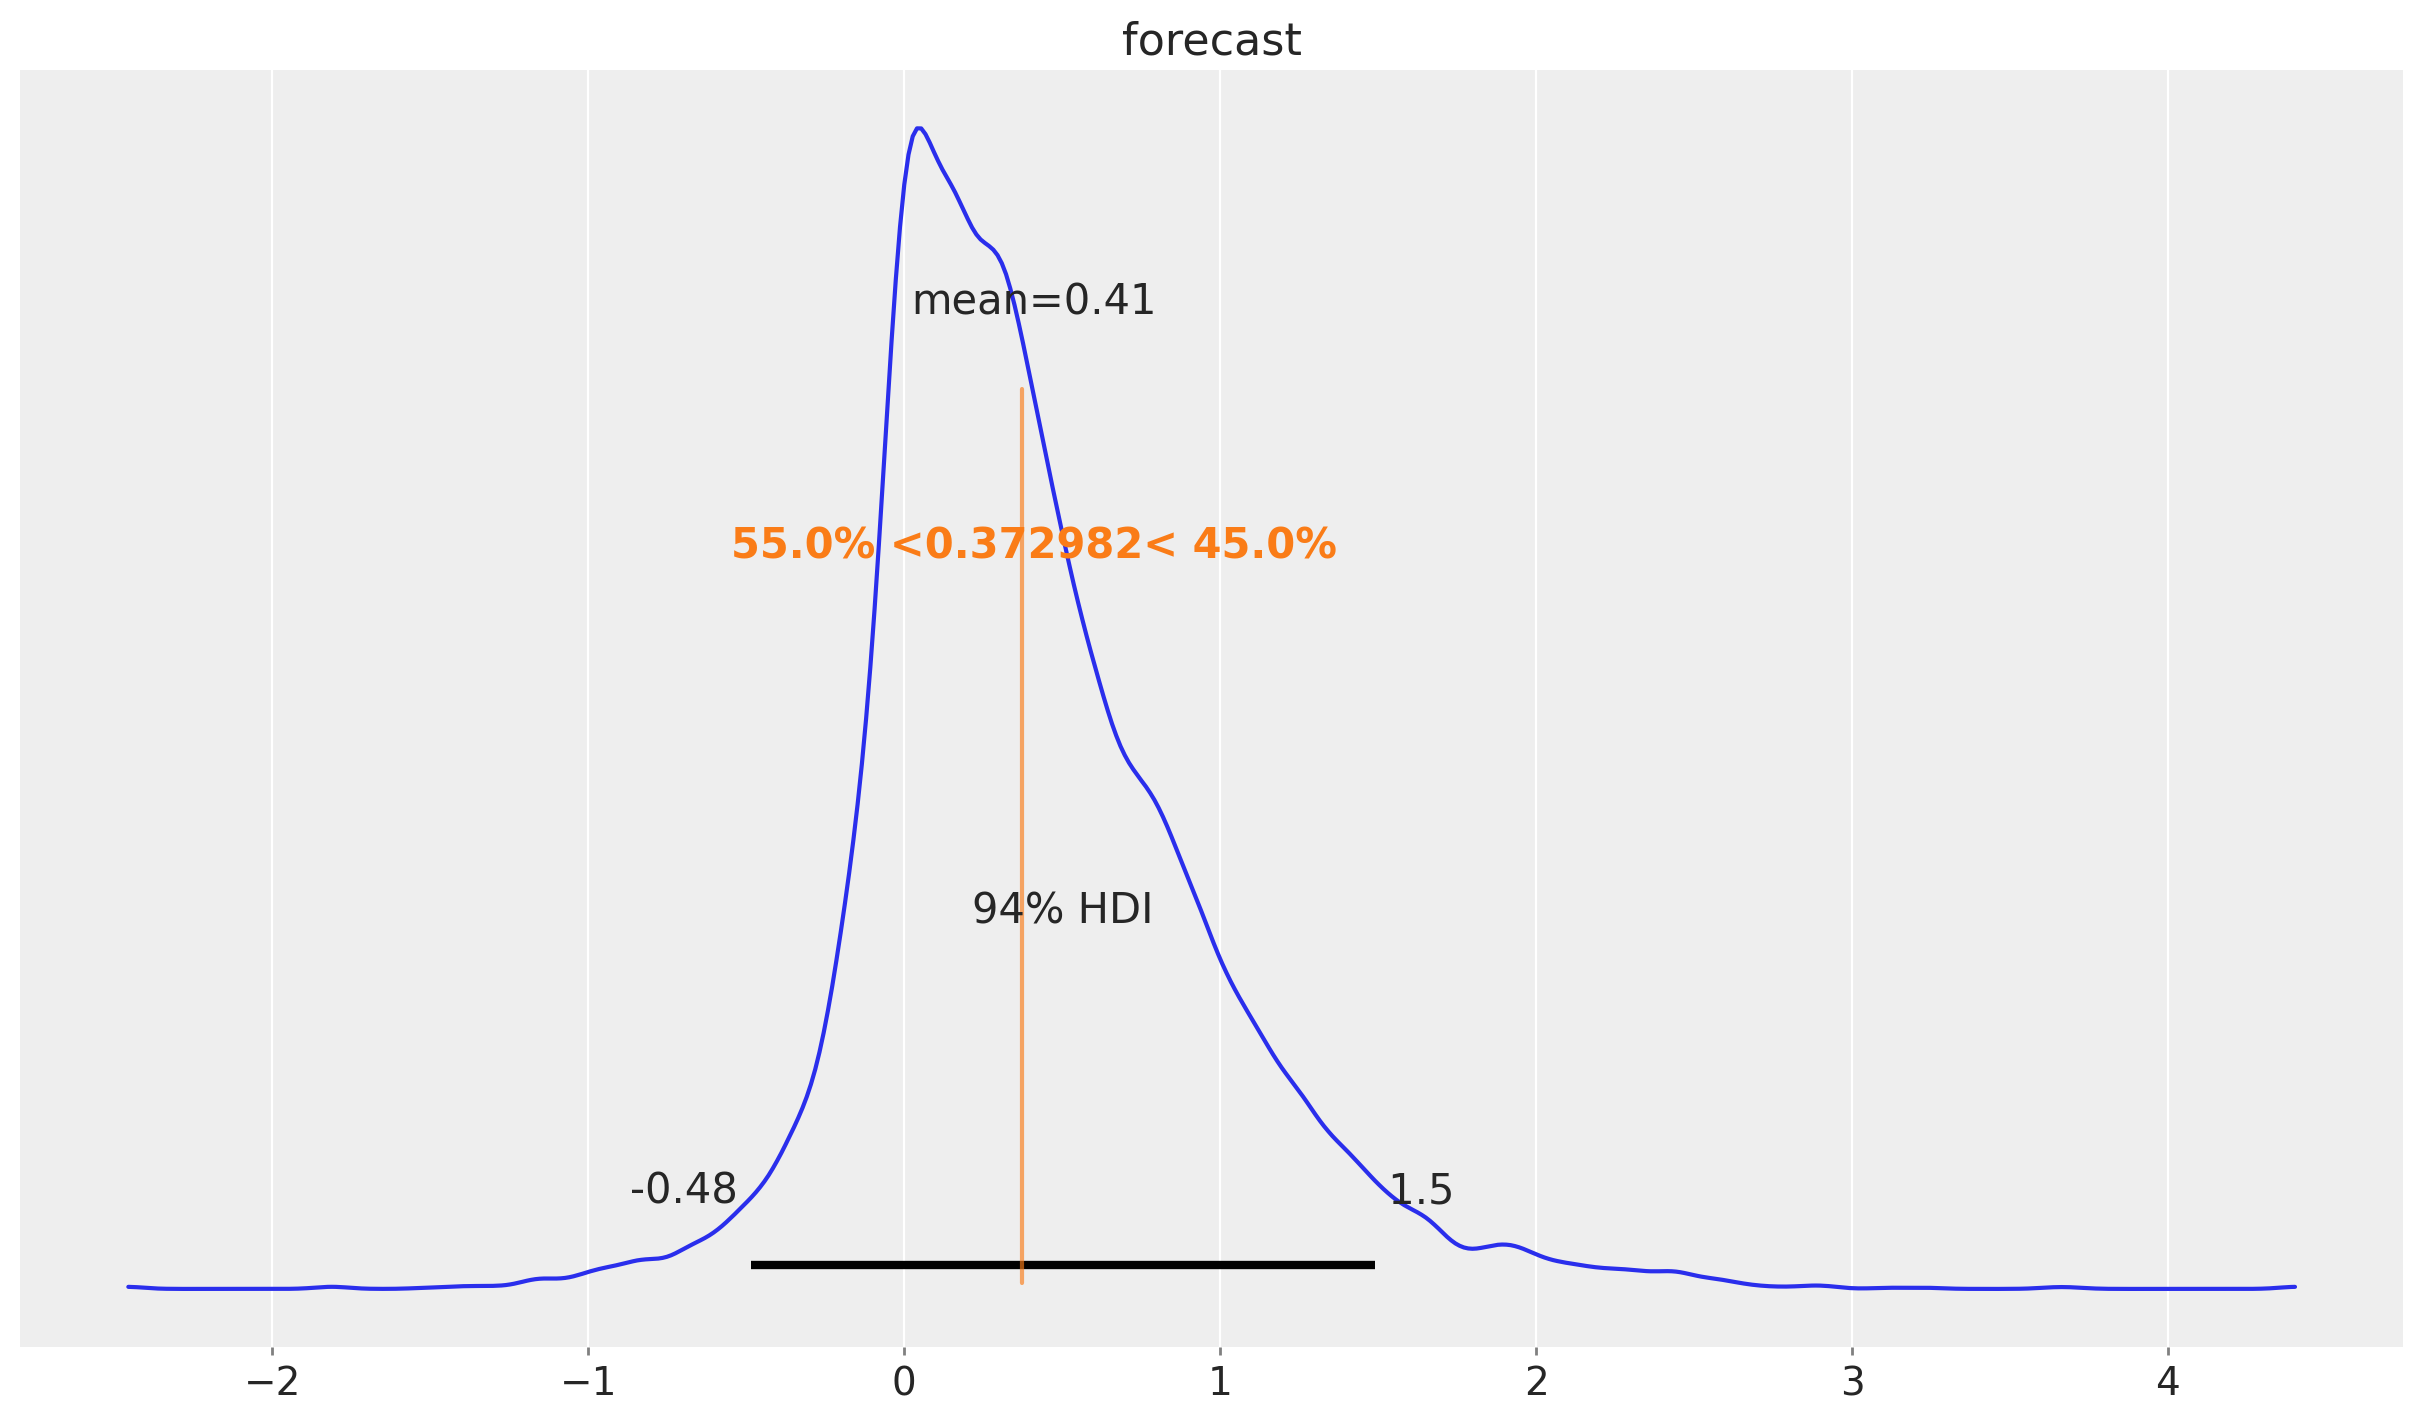

In [21]:
az.plot_posterior(
    posterior_predictive["posterior_predictive"]["forecast"].sel(t=n_train),
    ref_val=sf_forecast["CrostonOptimized"].head(1).item(),
)

We indeed see that the forecast is skewed to the right.